In [1]:
suppressPackageStartupMessages(library(emmeans))
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages(library(effects))
suppressPackageStartupMessages(library(nlme))

# Using GLS in `R`
In the previous part of this lesson, we discussed the theory behind GLS. Now we turn to how GLS is implemented within `R`. We saw some examples of using the `gls()` function from `nlme` last semester. At that point, we only focused on the use of the `weights=` argument with different variance structures (e.g. `varIdent()`, `varPower()` etc.). However, there is also a `correlation=` argument that similarly takes a number of pre-specified correlation structures. We can use these two arguments together to form a final variance-covariance matrix that consists of *both* correlation and heterogenous variance groups. In this part of the lesson, we will explore `gls()` further using a simple repeated measures one-way ANOVA model. We will see examples of using `gls()` on more complex datasets in the workshop this week.

## The GLS One-way ANOVA

### The Data
The `datarium` package contains a dataset called `selfesteem` that contains measurements of a self-esteem score taken at 3 different time points per-subject. We can see how this is structured below

In [2]:
library('datarium')
data('selfesteem')
head(selfesteem)

  id       t1       t2       t3
1  1 4.005027 5.182286 7.107831
2  2 2.558124 6.912915 6.308434
3  3 3.244241 4.443434 9.778410
4  4 3.419538 4.711696 8.347124
5  5 2.871243 3.908429 6.457287
6  6 2.045868 5.340549 6.653224

We can then convert it to long-format to make it suitable for univariate modelling

In [3]:
library('reshape2')

# repeats and number of subjects
t <- 3
n <- dim(selfesteem)[1]

# reshape wide -> long
selfesteem.long <- melt(selfesteem,            # wide data frame
                        id.vars='id',          # what stays fixed?
                        variable.name="time",  # name for the new predictor
                        value.name="score")    # name for the new outcome

selfesteem.long <- selfesteem.long[order(selfesteem.long$id),] # order by ID
rownames(selfesteem.long) <- seq(1,n*t)                        # fix row names
selfesteem.long$id        <- as.factor(selfesteem.long$id)     # convert ID to factor

print(head(selfesteem.long))

  id time    score
1  1   t1 4.005027
2  1   t2 5.182286
3  1   t3 7.107831
4  2   t1 2.558124
5  2   t2 6.912915
6  2   t3 6.308434


Our aim will be to look at different ways of modelling the covariance structure within this dataset, using GLS. In general, because there are 3 repeated measurements, the covariance matrix for each subject will be $3 \times 3$. Because we always assume that the subject are independent, we will be working with a block-diagonal structure of the form

$$
\text{Var}\left(\boldsymbol{\epsilon}\right) = 
\begin{bmatrix}
    \boldsymbol{\Sigma}_{1} & \mathbf{0}              & \mathbf{0}              & \cdots & \mathbf{0}              \\
    \mathbf{0}              & \boldsymbol{\Sigma}_{2} & \mathbf{0}              & \cdots & \mathbf{0}              \\
    \mathbf{0}              & \mathbf{0}              & \boldsymbol{\Sigma}_{3} & \cdots & \mathbf{0}              \\
    \vdots                  & \vdots                  & \vdots                  & \ddots & \vdots                  \\          
    \mathbf{0}              & \mathbf{0}              & \mathbf{0}              & \cdots & \boldsymbol{\Sigma}_{n} \\
\end{bmatrix},
$$

where each $\boldsymbol{\Sigma}_{i}$ is an *identical* $3 \times 3$ matrix and each $\mathbf{0}$ is a $3 \times 3$ matrix of zeros. As such, for subject $i$, our decisions centre on how the following matrix is parameterised

$$
\boldsymbol{\Sigma}_{i} = 
\begin{bmatrix}
    \sigma^{2}_{1} & \sigma_{12}    & \sigma_{13}    \\
    \sigma_{12}    & \sigma^{2}_{2} & \sigma_{23}    \\
    \sigma_{13}    & \sigma_{23}    & \sigma^{2}_{3} \\
\end{bmatrix}.
$$

### The `gls()` Syntax
... The equivalent model to the repeated measures ANOVA would be

In [4]:
library('nlme')
library('Matrix')

gls.mod.CompSymm <- gls(score ~ time, correlation=corCompSymm(form= ~ 1|id), data=selfesteem.long)

print(gls.mod.CompSymm)

Generalized least squares fit by REML
  Model: score ~ time 
  Data: selfesteem.long 
  Log-restricted-likelihood: -38.00009

Coefficients:
(Intercept)      timet2      timet3 
   3.140122    1.793820    4.496220 

Correlation Structure: Compound symmetry
 Formula: ~1 | id 
 Parameter estimate(s):
       Rho 
-0.1765313 
Degrees of freedom: 30 total; 27 residual
Residual standard error: 0.8859852 


... We can therefore view $\hat{\boldsymbol{\Sigma}_{i}}$ for a given subject. For instance, the estimated covariance structure for the subject with `id = '1'` is

In [5]:
Sigma.i <- getVarCov(gls.mod.CompSymm, individual='1') # get covariance
print(Sigma.i)


Marginal variance covariance matrix
         [,1]     [,2]     [,3]
[1,]  0.78497 -0.13857 -0.13857
[2,] -0.13857  0.78497 -0.13857
[3,] -0.13857 -0.13857  0.78497
  Standard Deviations: 0.88599 0.88599 0.88599 


So here we can actually *see* the compound symmetric structure, as all the diagonal elements are the same and all the off-diagonal elements are the same. It can also be useful to *visualise* this matrix, to make the structure clear. To do so, we load the `Matrix` package to convert the output of `getVarCov()` to a `Matrix` and then visualise it with the `image` function

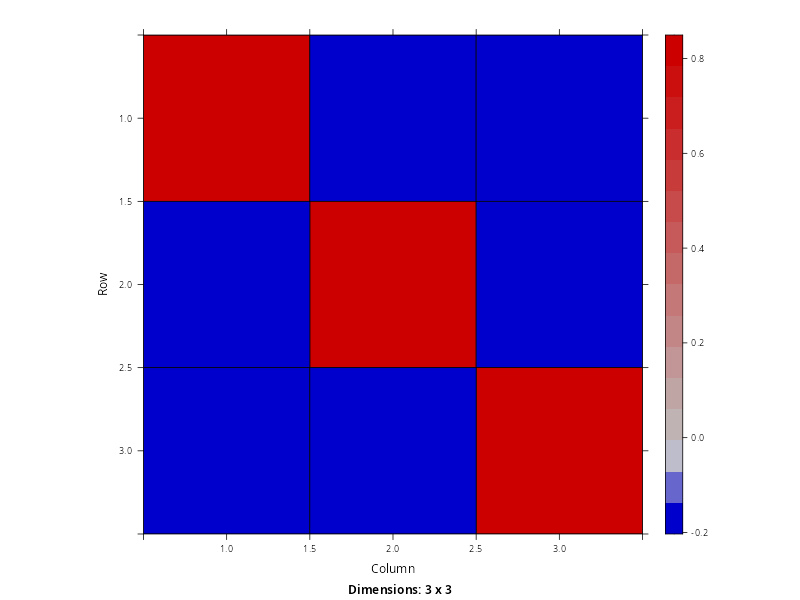

In [6]:
image(as(Sigma.i, "Matrix"))

### Understanding the `form=` Syntax
The `form=` syntax can take a little getting used to, but it is worth making an effort to understand because this is *the* way that the structure of the covariance matrix is defined. To facilitate this, we will use the `corSymm()` function as an example, because this defines a *completely unstructured* covariance matrix. As such, the way that `form=` is written will fully determine how this matrix is estimated. 

To begin with, the most basic structure would be `form= ~ 1|id`. Here, the factor on the *right-hand* side of `|` defines the *blocks*. So each level of `id` defines a separate independent block and we have implied a block-diagonal structure to the covariance matrix. The variable on the *left-hand* side of `|` defines the structure *within* each block. If we just use `1` here, it implies a completely *unstructured* approach where every element is estimated separately. So, `1|id` means "estimate a completely unconstrained covariance block for each subject". 

Now, imagine the situation where the repeated measurements are taken across time. If we have multiple replications at each time-point (e.g. each subject was measured 4 times at each time-point) then this provides the opportunity for additional structure. For instance, we can specify `form= ~ time|id`, which still defines a blocked structure, but within each block we are saying that the variable `time` defines our *occasion* or *order*. If we do this, the covariance structure within a block will be defined in terms of `time`, so that the replications at each time-point would share a correlation. If we instead specified `form= ~ 1|id` then each block would be *fully unconstrained*. So, every pair of replications within each time-point would have a different correlation. If we had *no* replications at each time-points, then `form= ~ time|id` and `form= ~ 1|id` would be *identical*.  This idea is visualised below for a single block (i.e. subject $i$ with covariance matrix $\boldsymbol{\Sigma}_{i}$) from an experiment with 3 time-points and 4 replications within each time-point. Hopefully this makes the distinction and its relationship with the syntax clearer.

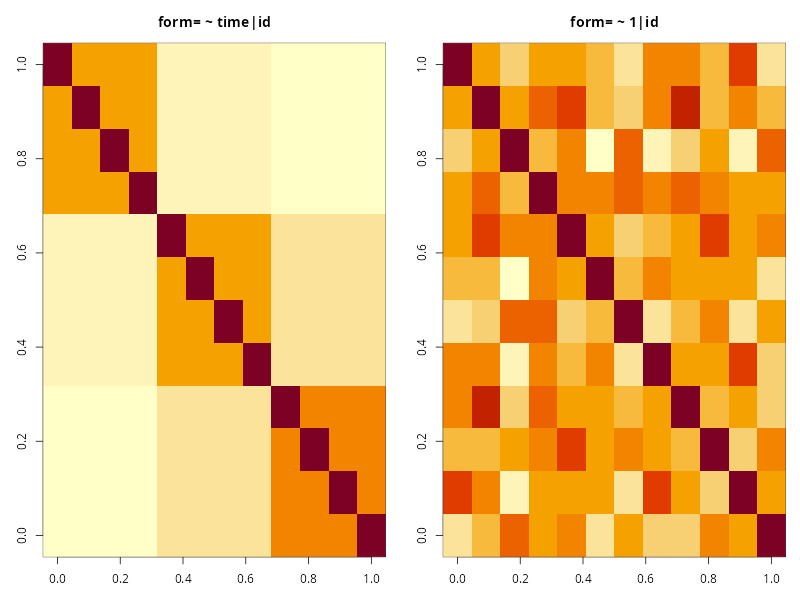

In [7]:
## Same idea as before, but using base graphics throughout

set.seed(1)

Tt   <- 3      # time points
Rrep <- 4      # replicates per time
n    <- Tt * Rrep

## ---- (A) Collapsed by time (what ~ time | id implies) ----
R_time <- matrix(c(
  1.00, 0.30, 0.10,
  0.30, 1.00, 0.20,
  0.10, 0.20, 1.00
), nrow = 3, byrow = TRUE)

rho_within <- c(0.60, 0.55, 0.50)

R_collapsed <- matrix(0, n, n)
time_index <- rep(1:Tt, each = Rrep)

for (ti in 1:Tt) {
  for (tj in 1:Tt) {
    ii <- which(time_index == ti)
    jj <- which(time_index == tj)

    if (ti == tj) {
      B <- matrix(rho_within[ti], Rrep, Rrep)
      diag(B) <- 1
      R_collapsed[ii, jj] <- B
    } else {
      R_collapsed[ii, jj] <- R_time[ti, tj]
    }
  }
}

## ---- (B) Fully unstructured across rows (~ 1 | id) ----
A <- matrix(rnorm(n * n), n, n)
S <- A %*% t(A)
R_unconstrained <- cov2cor(S)

## ---- Plot side-by-side with base graphics ----
par(mfrow = c(1, 2), mar = c(3, 3, 3, 1))

graphics::image(R_collapsed[n:1, ],
                main = "form= ~ time|id",
                xlab = "obs", ylab = "obs")

graphics::image(R_unconstrained[n:1, ],
                main = "form= ~ 1|id",
                xlab = "obs", ylab = "obs")


Note that this syntax will depend upon the type of structure used. For instance, `corCompSymm()` will ignore anything other than a `1` on the left-hand side of `|`, because a compound symmetric structure only has a single correlation for all observations within a block. So, you need to think about the *structure* you are using, how the *blocks* are defined for that structure using the term on the *right* of `|`, and how that structure is defined *within* a block using the terms on the *left* of `|`. We will see more examples of this syntax below and in the workshop this week.

### The Fully Unconstrained Covariance Structure
In the example above, we stuck to the restrictive assumptions of the repeated measures ANOVA and specified a covariance structure that was *compound symmetric*. However, the whole point of the GLS framework is that we can lift this assumption and specify more complex dependency structures. So, we will now consider a *completely unconstrained* covariance structure, where all correlations *and* all variances are free to vary. Note that this is the *opposite extreme* to the repeated measures ANOVA. There may well be a more appropriate structure available that is somewhere in between. For now, we will just focus on the unconstrained structure. In the accompanying workshop, we will examine some alternatives as well as how to use *model comparisons* to choose between them.

In order to specify a completely unconstrained structure, we need to combine both the `correlation=` option and the `weights=` option. Both of these take a `form=` argument, structured in the same way as above. For the correlation, we can use `corSymm(form= ~ 1|id)`. This specifies a block-diagonal correlation structure, where each block consists of a completely unstructured correlation matrix. For the variance, we can use `varIdent(form= ~ 1|time)`. This specifies a block-diagonal variance structure, where each block consists of a constant variance and the blocks are defined by the factor variable `time`. So, together, this gives us unconstrained correlation between the repeated measurements, and different variances for each level of `time`. The model is then 

In [8]:
gls.mod.Unconstrained <- gls(score ~ time, 
                             correlation =  corSymm(form= ~ 1|id), 
                             weights     = varIdent(form= ~ 1|time), 
                             data        = selfesteem.long)

and we can view the covariance matrix that has been estimated using

Marginal variance covariance matrix
         [,1]     [,2]     [,3]
[1,]  0.30449 -0.12729  0.22736
[2,] -0.12729  0.74489 -0.51578
[3,]  0.22736 -0.51578  1.30550
  Standard Deviations: 0.55181 0.86307 1.1426 


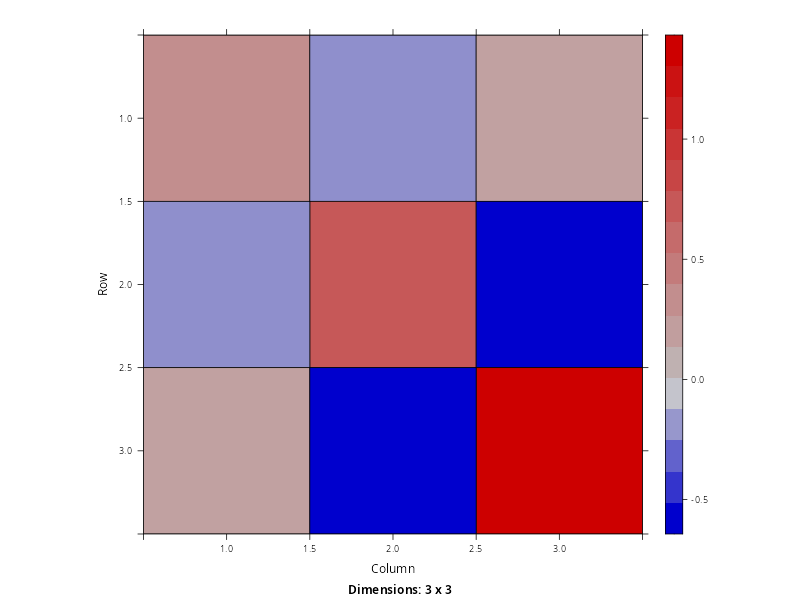

In [9]:
Sigma.i <- getVarCov(gls.mod.Unconstrained, individual='1')
print(Sigma.i)
image(as(Sigma.i, "Matrix"))

So, we can see how this syntax has allowed *both* the correlation to be unconstrained and the variances to be unconstrained. This is the *most general* covariance structure we can have for this dataset and thus represents the *most flexible* alternative to the assumptions of the repeated measures ANOVA.

## Assumptions and Visualisations
Before we get to discussing the tricky topic of inference, we also need to consider how to check the assumptions and visualise the GLS model. Although the plain `lm()` functions allows a variety of diagnostic plots, calling `plot()` on a GLS model will only give us a single visualisation. As such, if we want something similar we need to construct these plots ourselves, with some caveats.

### Assumptions Plots
In principle, all the plots we saw previously with `lm()` can still be defined using a model fit using `gls()`. However, there are two important caveats. 

Firstly, this is true only when working with the *corrected* errors. In other words, the errors that result from *removing* the covariance structure. Technically, this means we need to assume that the covariance structure we have is *correct*, as the assumptions of the normal linear model only apply if we have managed to remove the covariance structure *perfectly*. Given that this is not going to be true under FGLS, we need to be slightly more cautious about the interpretation of these types of plots.

Secondly, *leverage* and *Cook's Distance* are not defined under GLS. It may be possible to calculate some variant that is *similar* in spirit, but this is messy and would need to be scripted manually. As such, we will skip the leverage plot and, in its place, provide a visualisation of the covariance structure as a diagnostic measure, to make sure the estimated structure is as expected.

In the drop-down below is the definition of a function called `plot.gls()` that will create some visualisations that are similar in spirit to those from the normal linear model. These are all calculated using the residuals extracted using `resid(mod, type='normalized')`, which are residuals that have been *corrected* for the covariance structure and are *standardised*.  

In [10]:
plot.gls <- function(mod, timeseries=FALSE){

  w <- resid(mod, type="normalized")
  f <- fitted(mod)

  par(mfrow=c(2,2))

  # Residuals vs fitted
  plot(f, w, main='Residuals vs fitted')
  lines(lowess(f,w))

  # Normal Q-Q
  qqnorm(w) 
  qqline(w)
  
  # Scale-Location
  plot(f, sqrt(abs(w)), main='Scale-Location')
  lines(lowess(f,sqrt(abs(w))))

  # Either plot of the ACF, or a visualisation of the marginal covariance structure
  if (timeseries==TRUE){
    acf(w)                                   
  } else {
    V <- getVarCov(mod)
    graphics::image(as.matrix(V)[nrow(V):1, ], main='Marginal covariance structure')
  }
}

Applying this function to the results from the model with the unconstrained covariance structure gives

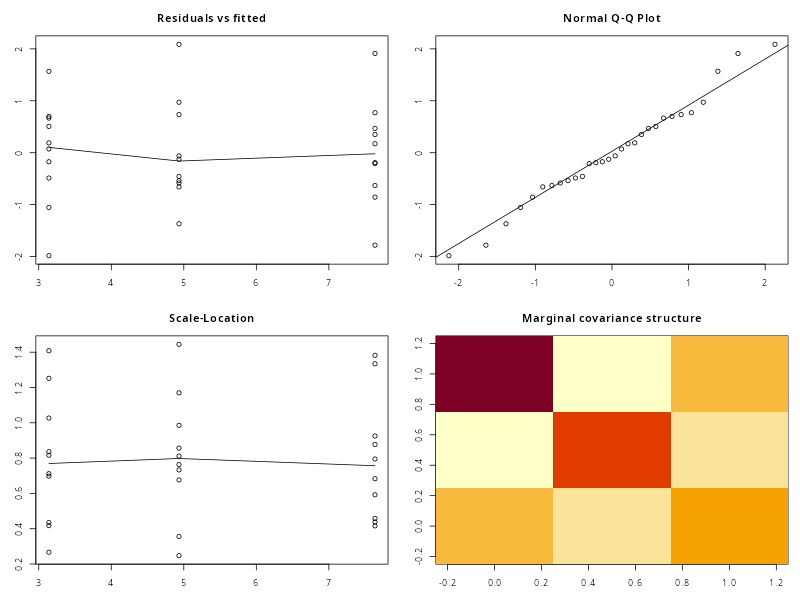

In [11]:
plot.gls(gls.mod.Unconstrained )

As way of comparison, the model with the compound symmetric structure gives

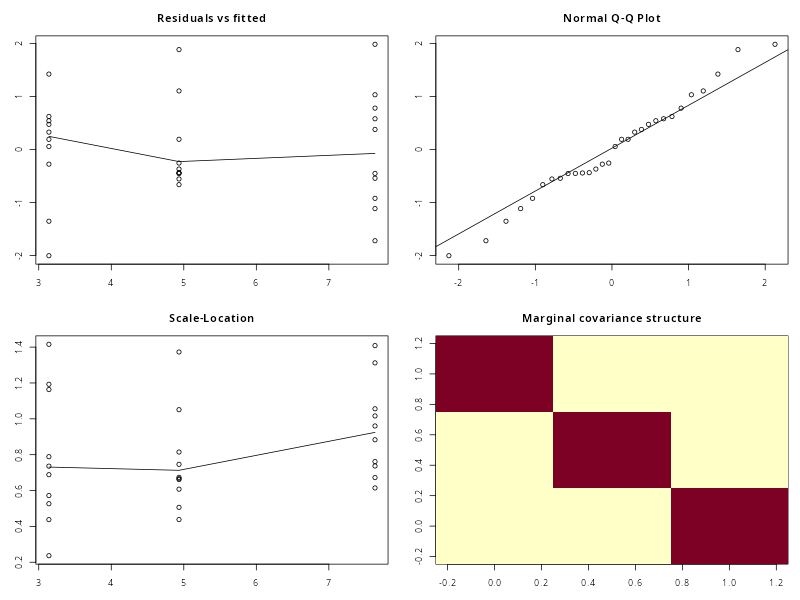

In [12]:
plot.gls(gls.mod.CompSymm)

which does appear qualitatively *worse*, thus suggesting that a more complex covariance structure provides a better model fit.

### Visualising the Model

## Inference Using `gls()`
Finally, we get to the thorny topic of *inference* using a `gls()` model.

### Coefficient Tests
... The key is understanding that the `gls()` function is designed to act *as if* we were using GLS instead of FGLS. So irrespective of whether we *give* `gls()` a covariance structure or *estimate* a covariance structure, the function will act the same way. This is **Option 1a** from earlier in the lesson: assume $\hat{\boldsymbol{\Sigma}} = \boldsymbol{\Sigma}$ and *ignore* the problem entirely. Once we understand this, the behaviour of `gls()` makes complete sense.

### Omnibus Tests

### Follow-up Tests

## Viewing the Complete Covariance Structure

[^weights-foot]: This is why the argument in `gls()` was `weights=`.

[^corfunc-foot]: You can look up descriptions of all of these using `?corClasses` at the prompt. 

[^white-foot]: This is sometimes known as *whitening* the data. This is a term you may come across in the neuroimaging literature, particularly in relation to how fMRI is analysed.

[^emmeans-foot]: The `mode=` option has been set to `df.error` so that the reported test matches the table from `summary()`. `emmeans` actually has some better ways of adjusting the degrees of freedom to accommodate the uncertainty in estimating $\boldsymbol{\Sigma}$, but this is a complication we will leave to one side for now.